# <center>Data Mining Project Code</center>

** **
## <center>*03 - Cuisine Preference Clustering*</center>

** **

In this notebook, we aim to understand customer behaviors and preferences by clustering them based on their culinary orders. By segmenting customers according to the types of cuisines they frequently order, we can uncover patterns in their consumption habits. This information will allow businesses to tailor marketing strategies, optimize inventory, and offer personalized recommendations, ultimately enhancing the customer experience.

The primary goal of this notebook is to apply unsupervised learning techniques to identify distinct customer groups based on their preference for different cuisines. We will utilize clustering algorithms such as KMeans, Hierarchical Clustering, SOM and Density-Based Algorithms to form these groups, and evaluate the clustering quality using various metrics like R², Silhouette Score, and Calinski-Harabasz Index.

At the end, we will compare our best solutions and explore the best one, creating customer profiles for each segment and interpreting their characteristics. By doing so, we aim to provide actionable insights for businesses to enhance customer satisfaction and improve operational efficiencies.


The members of the `team` are:
- Ana Farinha  - 20211514
- António Oliveira - 20211595
- Mariana Neto - 20211527
- Salvador Domingues - 20240597


# Table of Contents

<a class="anchor" id="top"></a>


1. [Importing Libraries & Data](#1.-Importing-Libraries-&-Data) <br><br>

1. [Clustering](#2.-Clustering) <br><br>


# 1. Importing Libraries & Data

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display 

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Clustering algorithms
from sklearn.cluster import AgglomerativeClustering, KMeans
from kmodes.kprototypes import KPrototypes

# Evaluation
from sklearn.metrics import silhouette_score, silhouette_samples

# Segmentation
import segmentation as s

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# Others
import functions as f

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

path = './plots/customer_data/'

<br>

**Customer data**

In [2]:
data = pd.read_csv('data/data.csv', 
                   index_col = "customer_id")

outlier_data = pd.read_csv('data/outlier_data.csv', 
                   index_col = "customer_id")

customer_data = data[s.customer_info]
customer_data_outlier = outlier_data[s.customer_info]

In [3]:
customer_data['customer_region'] = customer_data['customer_region'].replace(0, '0000')
customer_data['customer_region'] = customer_data['customer_region'].astype(str)
customer_data['customer_region'].unique()

array(['2360', '8670', '4660', '2440', '0000', '4140', '2490', '8370',
       '8550'], dtype=object)

In [4]:
customer_data_outlier['customer_region'] = customer_data_outlier['customer_region'].replace(0, '0000')
customer_data_outlier['customer_region'] = customer_data_outlier['customer_region'].astype(str)
customer_data_outlier['customer_region'].unique()

array(['2440', '2360', '8670', '4140', '4660', '0000', '2490', '8370'],
      dtype=object)

In [5]:
customer_data

,customer_region,customer_age,is_repeat_customer
customer_id,,,
1b8f824d5e,2360,18,1
5d272b9dcb,8670,17,1
f6d1b2ba63,4660,38,1
180c632ed8,4660,27,1
4eb37a6705,4660,20,1
...,...,...,...
f4e366c281,8670,30,0
f6b6709018,8670,26,0
f74ad8ce3f,8670,24,0


In [6]:
customer_data_outlier

,customer_region,customer_age,is_repeat_customer
customer_id,,,
fd399c247b,2440,22,1
ef760c3a3c,2360,26,1
7b0661a6ba,2360,30,1
01ad9867f2,8670,29,1
c887818ebd,4140,32,1
...,...,...,...
0e60632fe2,8670,23,0
28ed1f1e3f,8670,20,0
4c06e104de,8670,25,0


<br>

# 2. Clustering

## 2.1 Scaling

In [7]:
scaler = MinMaxScaler()

For this data, we are going to consider only the feature `customer_age` given that its the only numerical in this dataset.

In [8]:
customer_data['customer_age'] = scaler.fit_transform(customer_data[['customer_age']])

In [9]:
customer_data_outlier['customer_age'] = scaler.fit_transform(customer_data_outlier[['customer_age']])

<br>

## 2.2 K-Prototypes

https://github.com/nicodv/kmodes/blob/7481a88841e67d99d47287ea7b8a36f4a14d5344/kmodes/kprototypes.py#L95

The cost_ attribute of the Kmodes/KPrototype algorithm measures the dissimilarity between the categorical object and the respective mode/centroid. This is commonly done using a method like Hamming Distance. Intuitive example of Hamming Distance:

For any two objects (say, A and B) in the dataset, the Hamming distance is the number of attributes for which A and B have different categories. For instance, if A = (Red, Small, Circle) and B = (Blue, Small, Square), the Hamming distance between A and B is 2, since they differ in color and shape. 

The cost then is the dissimilarity btn that data point and the mode of the cluster.

In terms of evaluation, the cost_ attributes could be used for a few different things:

Determining the quality of the cluster
Comparing different clustering solutions
Choosing the optimal number of clusters (using methods such as the Elbow method)
Determining algo convergence.
Benchmarking against other clustering configs.

## UMAP Embedding

One of the comparison methods will be visual, so we need a way to visualise the quality of clustering. We will be using Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) - a dimensionality reduction technique to embedd the data into 2 dimensions. This will allow us to visually see the groups of customers, and how well did the clustering algorithms do the job. There are 3 steps to get the proper embeddings:

1. Yeo-Johnson transform the numerical columns & One-Hot-Encode the categorical data
2. Embed these two column types separately
3. Combine the two by conditioning the numerical embeddings on the categorical embeddings as suggested here

https://github.com/AntonsRuberts/datascience_marketing/blob/master/KMeans_vs_KPrototypes.ipynb

Try this UMAP

In [10]:
import umap
##preprocessing categorical
categorical_type = customer_data.select_dtypes(include='object')
categorical_type = pd.get_dummies(categorical_type)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(customer_data.select_dtypes(include='object').columns) / customer_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(customer_data[['customer_age', 'is_repeat_customer']])
fit2 = umap.UMAP(metric='hamming').fit(categorical_type)

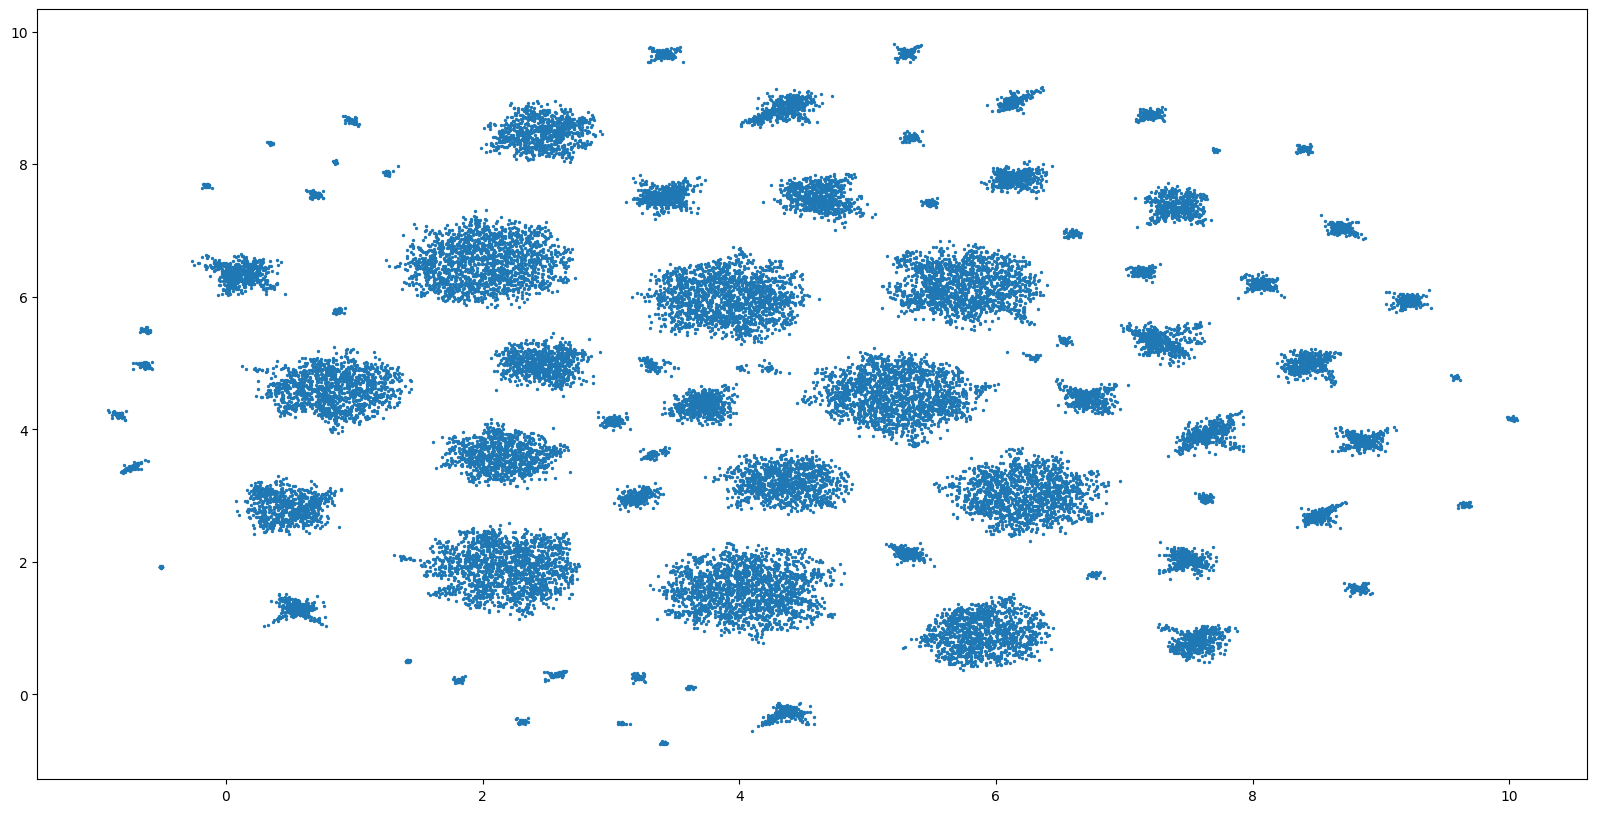

In [11]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(
    fit1._raw_data, intersection, fit1.n_components,
    fit1._initial_alpha, fit1._a, fit1._b,
    fit1.repulsion_strength, fit1.negative_sample_rate,
    200, 'random', np.random, fit1.metric,
    fit1._metric_kwds, False, {}, False
)

embedding_array = embedding[0]  

plt.figure(figsize=(20, 10))
plt.scatter(*embedding_array.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [12]:
def column_index(df, query_cols):
  '''
  returns the indices of the query_cols
  '''
  cols = df.columns.values
  sidx = np.argsort(cols)
  return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [13]:
cat_cols = ['customer_region', 'is_repeat_customer']
categorical_indices = column_index(customer_data, cat_cols)
categorical = list(categorical_indices)

In [14]:
cost = []
for cluster in range(2,16):
    try:
        model = KPrototypes(n_clusters=cluster, init="Cao", random_state=42)
        model.fit_predict(customer_data, categorical= categorical)
        cost.append(model.cost_)
        print("Cluster Initiation: {}".format(cluster))
    except:
        break

Cluster Initiation: 2
Cluster Initiation: 3
Cluster Initiation: 4
Cluster Initiation: 5
Cluster Initiation: 6
Cluster Initiation: 7
Cluster Initiation: 8
Cluster Initiation: 9
Cluster Initiation: 10
Cluster Initiation: 11
Cluster Initiation: 12
Cluster Initiation: 13
Cluster Initiation: 14
Cluster Initiation: 15


In [20]:
data_cost = pd.DataFrame({"Cluster":range(2,16),"Cost":cost})
data_cost

,Cluster,Cost
0,2,1389.648387
1,3,947.757982
2,4,822.801649
3,5,751.476915
4,6,697.487469
5,7,675.633828
6,8,638.035240
7,9,617.885751
8,10,491.774130
9,11,385.157168


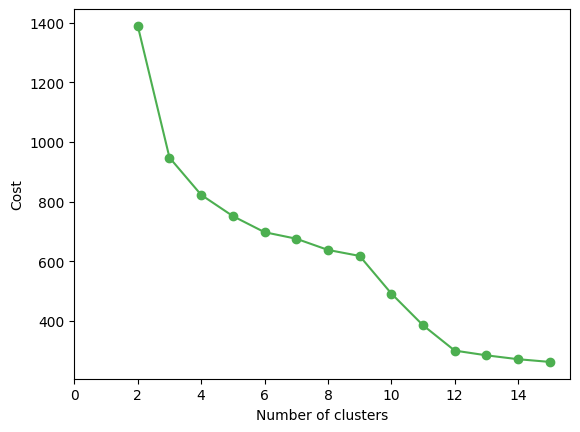

In [16]:
plt.plot(range(2, 16), cost, marker='o', color='#4CAF50')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.xticks(np.arange(0, 16, step=2))  
plt.show()

<br>

#### Number of clusters: 5

In [18]:
model_5 = KPrototypes(n_clusters= 5, init= "Cao",random_state=42)
clusters5 = model_5.fit_predict(customer_data, categorical= categorical)

In [19]:
customer_data["Cluster labels 5"]= model_5.labels_
customer_data["Segment 5"]= customer_data["Cluster labels 5"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth", 4:"Fifth"})

# Order the clusters
customer_data["Segment 5"] = customer_data["Segment 5"].astype("category")
customer_data["Segment 5"] = customer_data["Segment 5"].cat.reorder_categories(["First","Second","Third","Fourth","Fifth"])

customer_data.head()

,customer_region,customer_age,is_repeat_customer,Cluster labels 5,Segment 5
customer_id,,,,,
1b8f824d5e,2360,0.046154,1,2,Third
5d272b9dcb,8670,0.030769,1,4,Fifth
f6d1b2ba63,4660,0.353846,1,1,Second
180c632ed8,4660,0.184615,1,1,Second
4eb37a6705,4660,0.076923,1,1,Second


<br>

#### **Visualization of clusters**

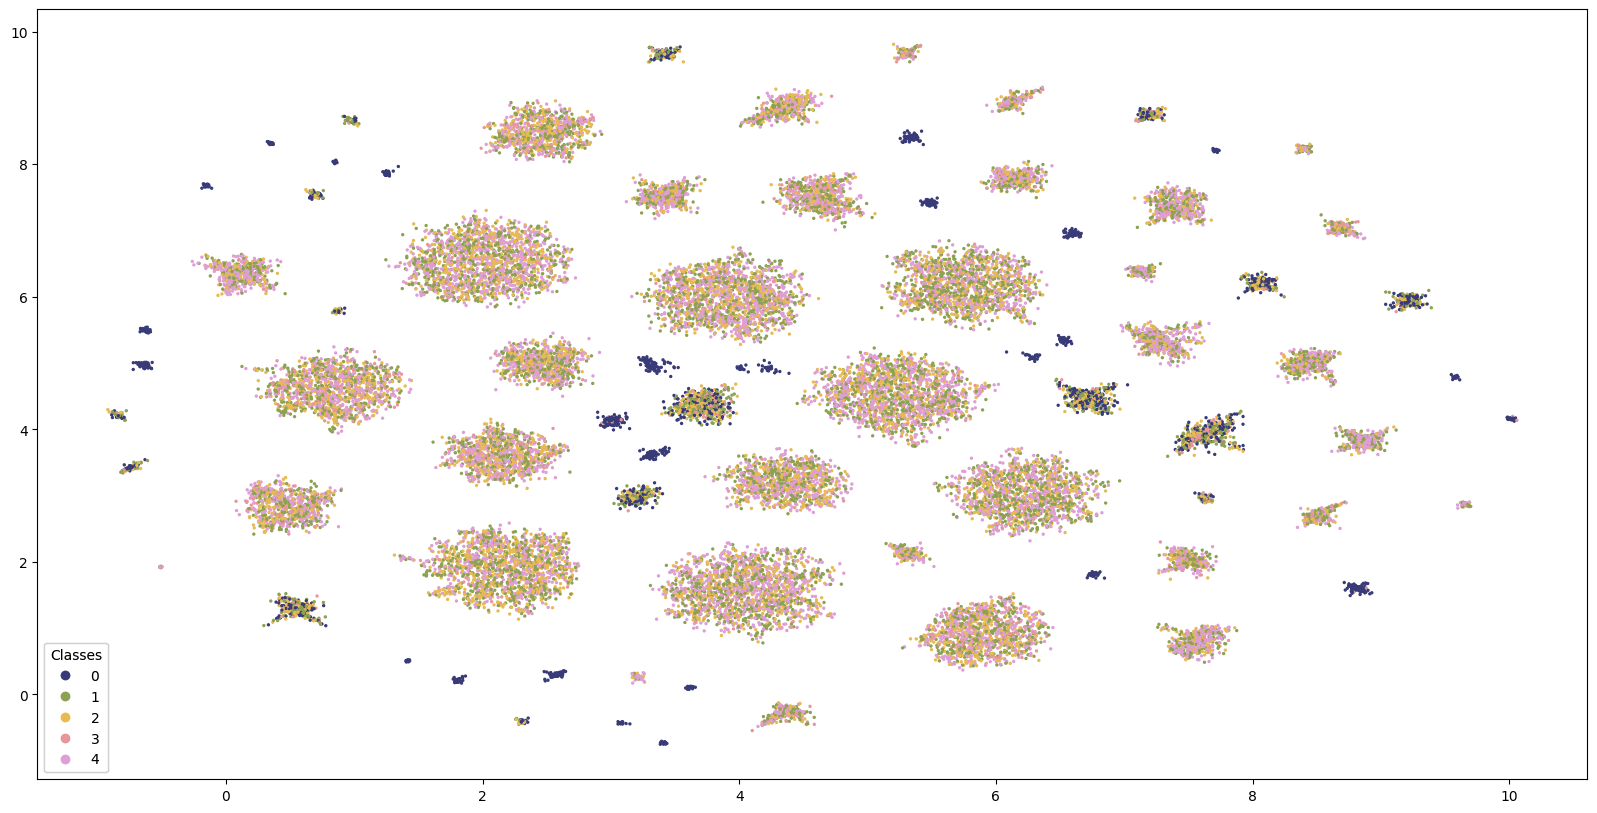

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_array[:, 0], embedding_array[:, 1], s=2, c=clusters5, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=4),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

<br>

#### Number of clusters: 6

In [34]:
customer_data_copy = customer_data.copy()
customer_data_copy = customer_data_copy.drop(['Cluster labels 5', 'Segment 5'], axis = 1)

In [35]:
model_6 = KPrototypes(n_clusters= 6, init= "Cao",random_state=42)
clusters6 = model_6.fit_predict(customer_data_copy, categorical= categorical)

In [36]:
customer_data["Cluster labels 6"]= model_6.labels_
customer_data["Segment 6"]= customer_data["Cluster labels 6"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth", 4:"Fifth", 5:"Sixth"})

# Order the clusters
customer_data["Segment 6"] = customer_data["Segment 6"].astype("category")
customer_data["Segment 6"] = customer_data["Segment 6"].cat.reorder_categories(["First","Second","Third","Fourth","Fifth","Sixth"])

customer_data.head()

,customer_region,customer_age,is_repeat_customer,Cluster labels 5,Segment 5,Cluster labels 6,Segment 6
customer_id,,,,,,,
1b8f824d5e,2360,0.046154,1,2,Third,2,Third
5d272b9dcb,8670,0.030769,1,4,Fifth,4,Fifth
f6d1b2ba63,4660,0.353846,1,1,Second,5,Sixth
180c632ed8,4660,0.184615,1,1,Second,1,Second
4eb37a6705,4660,0.076923,1,1,Second,1,Second


<br>

#### **Visualization of clusters**

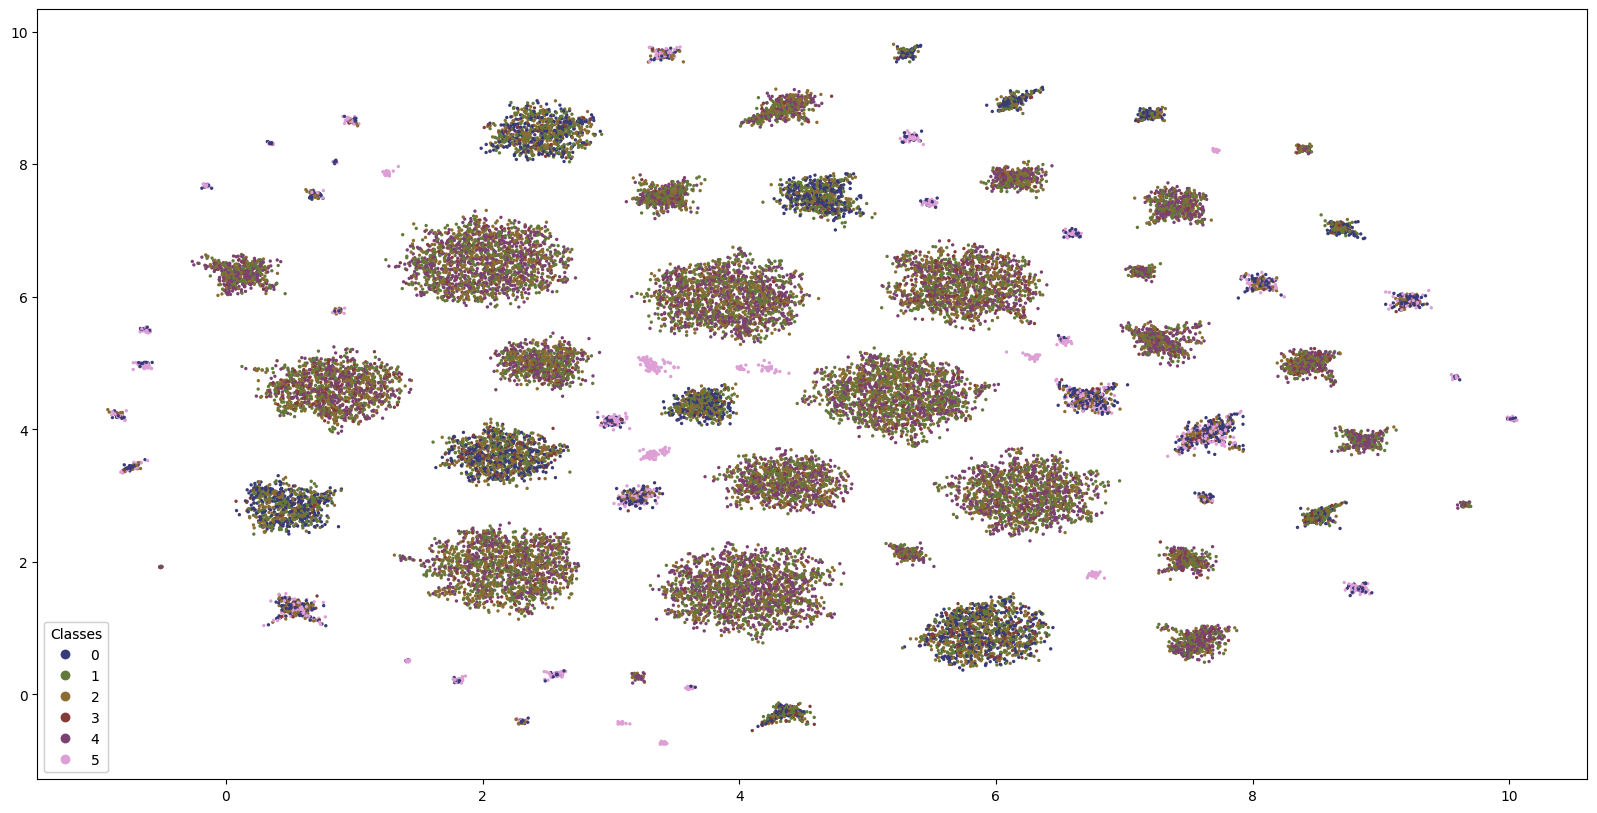

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_array[:, 0], embedding_array[:, 1], s=2, c=clusters6, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=5),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

<br>

#### Number of clusters: 7

In [38]:
model_7 = KPrototypes(n_clusters= 7, init= "Cao",random_state=42)
clusters7 = model_7.fit_predict(customer_data_copy, categorical= categorical)

In [40]:
customer_data["Cluster labels 7"]= model_7.labels_
customer_data["Segment 7"]= customer_data["Cluster labels 7"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth", 4:"Fifth", 5:"Sixth", 6:"Seventh"})

# Order the clusters
customer_data["Segment 7"] = customer_data["Segment 7"].astype("category")
customer_data["Segment 7"] = customer_data["Segment 7"].cat.reorder_categories(["First","Second","Third","Fourth","Fifth","Sixth", "Seventh"])

customer_data.head()

,customer_region,customer_age,is_repeat_customer,Cluster labels 5,Segment 5,Cluster labels 6,Segment 6,Cluster labels 7,Segment 7
customer_id,,,,,,,,,
1b8f824d5e,2360,0.046154,1,2,Third,2,Third,2,Third
5d272b9dcb,8670,0.030769,1,4,Fifth,4,Fifth,6,Seventh
f6d1b2ba63,4660,0.353846,1,1,Second,5,Sixth,4,Fifth
180c632ed8,4660,0.184615,1,1,Second,1,Second,1,Second
4eb37a6705,4660,0.076923,1,1,Second,1,Second,1,Second


<br>

#### **Visualization of clusters**

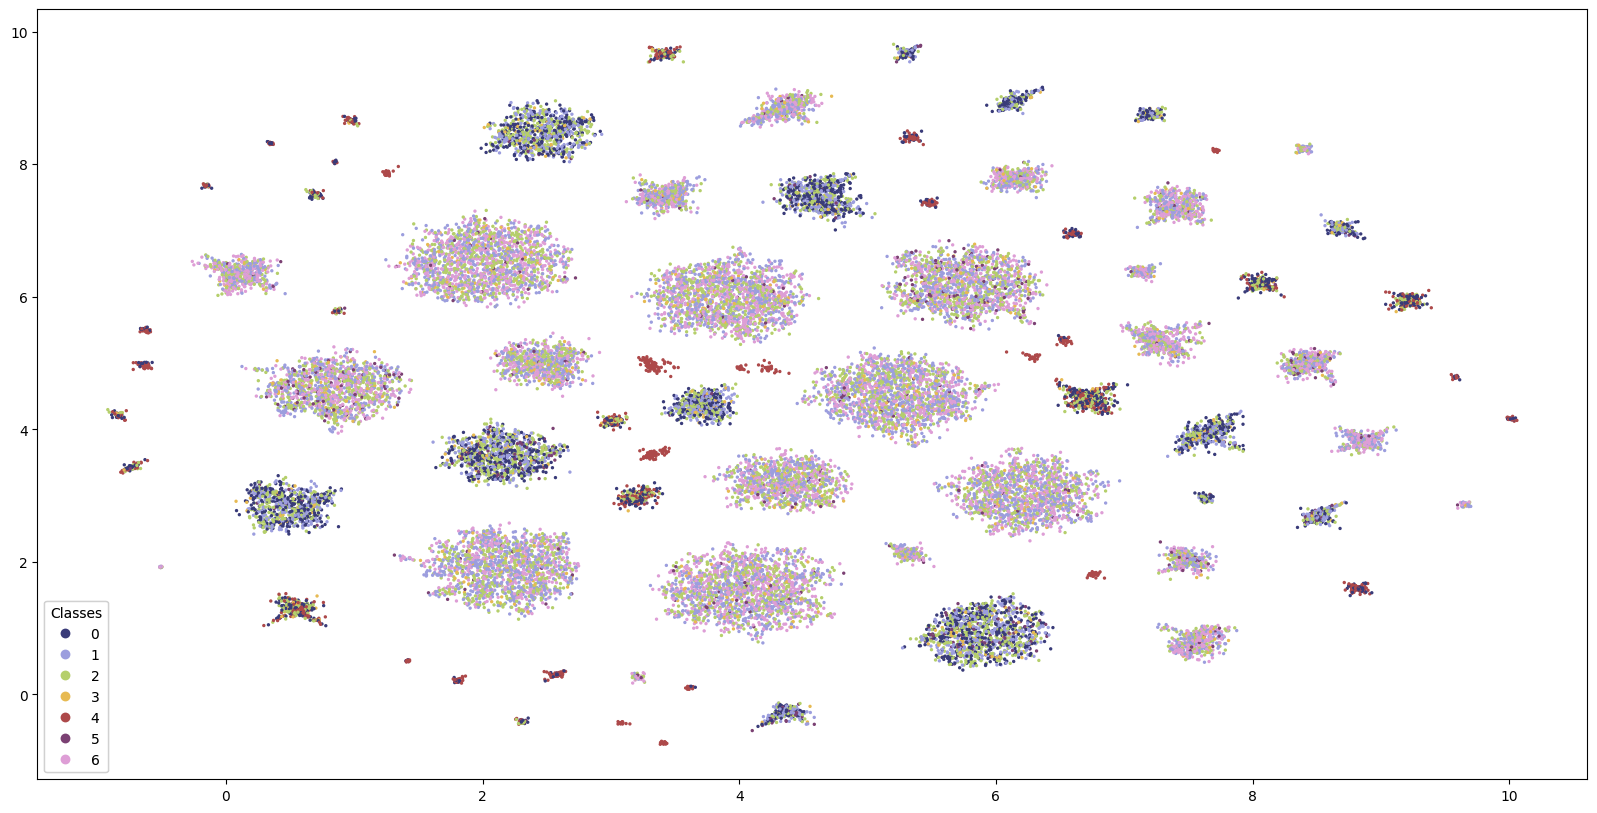

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_array[:, 0], embedding_array[:, 1], s=2, c=clusters7, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=6),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

<br>

#### Number of clusters: 12

In [43]:
model_12 = KPrototypes(n_clusters= 12, init= "Cao",random_state=42)
clusters12 = model_12.fit_predict(customer_data_copy, categorical= categorical)

In [44]:
customer_data["Cluster labels 12"]= model_12.labels_
customer_data["Segment 12"]= customer_data["Cluster labels 12"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth", 4:"Fifth", 5:"Sixth", 6:"Seventh", 7:"Eighth", 8:"Ninth", 9:"Tenth", 10:"Eleventh", 11:"Twelfth"})

# Order the clusters
customer_data["Segment 12"] = customer_data["Segment 12"].astype("category")
customer_data["Segment 12"] = customer_data["Segment 12"].cat.reorder_categories(["First","Second","Third","Fourth","Fifth","Sixth","Seventh","Eighth", "Ninth", "Tenth", "Eleventh","Twelfth"])

customer_data.head()

,customer_region,customer_age,is_repeat_customer,Cluster labels 5,Segment 5,Cluster labels 6,Segment 6,Cluster labels 7,Segment 7,Cluster labels 12,Segment 12
customer_id,,,,,,,,,,,
1b8f824d5e,2360,0.046154,1,2,Third,2,Third,2,Third,2,Third
5d272b9dcb,8670,0.030769,1,4,Fifth,4,Fifth,6,Seventh,4,Fifth
f6d1b2ba63,4660,0.353846,1,1,Second,5,Sixth,4,Fifth,5,Sixth
180c632ed8,4660,0.184615,1,1,Second,1,Second,1,Second,1,Second
4eb37a6705,4660,0.076923,1,1,Second,1,Second,1,Second,1,Second


<br>

#### **Visualization of clusters**

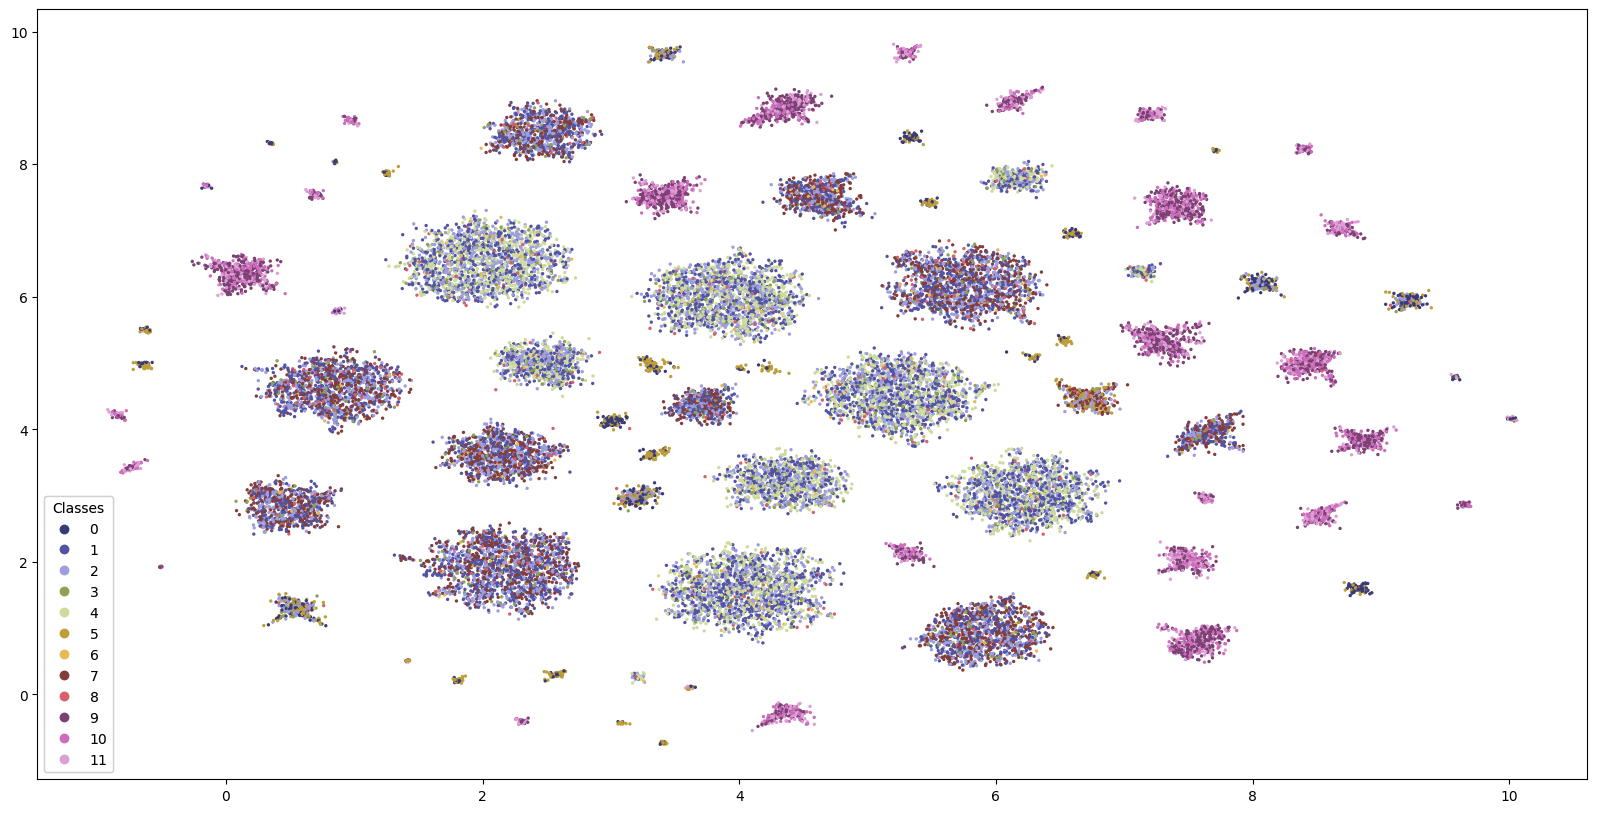

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_array[:, 0], embedding_array[:, 1], s=2, c=clusters12, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=11),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

<br>

#### Number of clusters: 14

In [47]:
model_14 = KPrototypes(n_clusters= 14, init= "Cao",random_state=42)
clusters14 = model_14.fit_predict(customer_data_copy, categorical= categorical)

In [48]:
customer_data["Cluster labels 14"]= model_14.labels_
customer_data["Segment 14"]= customer_data["Cluster labels 14"].map({0:"First", 1:"Second", 2:"Third", 3:"Fourth", 4:"Fifth", 5:"Sixth", 6:"Seventh", 7:"Eighth", 8:"Ninth", 9:"Tenth", 10:"Eleventh", 11:"Twelfth", 12: "Thirteenth", 13: "Fourteenth"})

# Order the clusters
customer_data["Segment 14"] = customer_data["Segment 14"].astype("category")
customer_data["Segment 14"] = customer_data["Segment 14"].cat.reorder_categories(["First","Second","Third","Fourth","Fifth","Sixth","Seventh","Eighth", "Ninth", "Tenth", "Eleventh","Twelfth","Thirteenth","Fourteenth"])

customer_data.head()

,customer_region,customer_age,is_repeat_customer,Cluster labels 5,Segment 5,Cluster labels 6,Segment 6,Cluster labels 7,Segment 7,Cluster labels 12,Segment 12,Cluster labels 14,Segment 14
customer_id,,,,,,,,,,,,,
1b8f824d5e,2360,0.046154,1,2,Third,2,Third,2,Third,2,Third,2,Third
5d272b9dcb,8670,0.030769,1,4,Fifth,4,Fifth,6,Seventh,4,Fifth,4,Fifth
f6d1b2ba63,4660,0.353846,1,1,Second,5,Sixth,4,Fifth,5,Sixth,5,Sixth
180c632ed8,4660,0.184615,1,1,Second,1,Second,1,Second,1,Second,1,Second
4eb37a6705,4660,0.076923,1,1,Second,1,Second,1,Second,1,Second,1,Second


<br>

#### **Visualization of clusters**

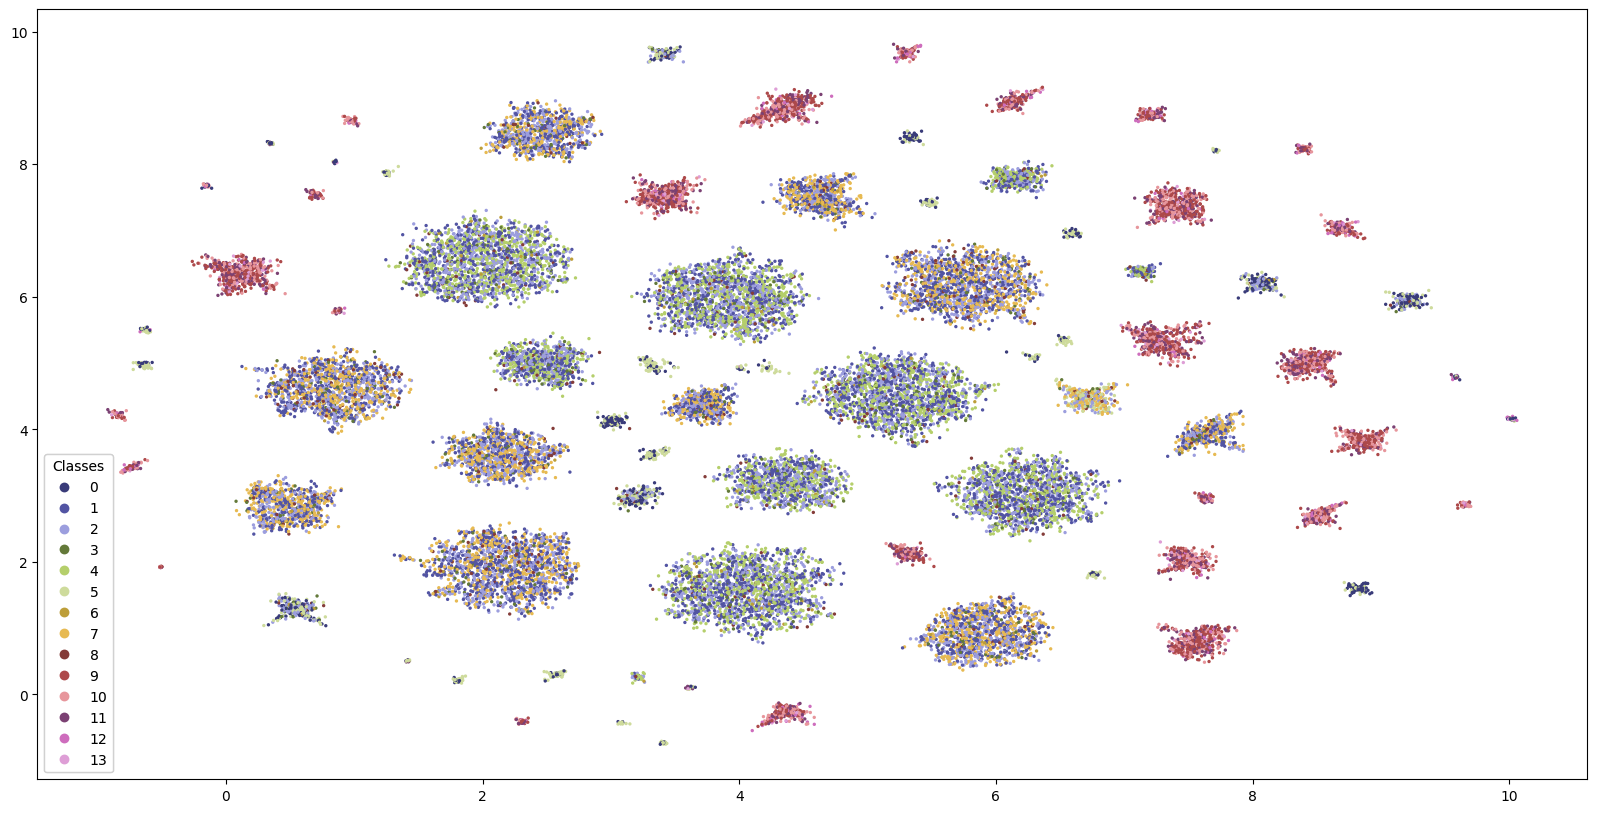

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding_array[:, 0], embedding_array[:, 1], s=2, c=clusters14, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=13),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)